# Face Recognition

Face recognition problems commonly fall into one of two categories: 

**Face Verification** "Is this the claimed person?" This is a 1:1 matching problem.

**Face Recognition** "Who is this person?" This is a 1:K matching problem.

FaceNet learns a neural network that encodes a face image into a vector of 128 numbers. 
By comparing two such vectors, determine if two pictures are of the same person.


In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Lambda, Flatten, Dense
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K
K.set_image_data_format('channels_last')
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
import PIL

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
basicPath = "/content/drive/MyDrive/W4A1/"

In [22]:
# Load pretrained_model
from tensorflow.keras.models import model_from_json
json_file = open(basicPath+'keras-facenet-h5/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights(basicPath+'keras-facenet-h5/model.h5')

print(model.inputs)
print(model.outputs)

[<KerasTensor: shape=(None, 160, 160, 3) dtype=float32 (created by layer 'input_1')>]
[<KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'Bottleneck_BatchNorm')>]


In [23]:
FRmodel = model

By using a 128-neuron fully connected layer as its last layer, the model ensures that the output is an encoding vector of size 128.

Use the encodings to compare two face images
- By computing the distance between two encodings and thresholding, you can determine if the two pictures represent the same person

### The Triplet Loss

For an image $x$, its encoding is denoted as $f(x)$, where $f$ is the function computed by the neural network.

Training will use triplets of images $(A, P, N)$:

- A is an "Anchor" image--a picture of a person.
- P is a "Positive" image--a picture of the same person as the Anchor image.
- N is a "Negative" image--a picture of a different person than the Anchor image.

"triplet cost":

$$\mathcal{J} = \sum^{m}_{i=1} \large[ \small \underbrace{\mid \mid f(A^{(i)}) - f(P^{(i)}) \mid \mid_2^2}_\text{(1)} - \underbrace{\mid \mid f(A^{(i)}) - f(N^{(i)}) \mid \mid_2^2}_\text{(2)} + \alpha \large ] \small_+ $$

In [24]:
def triplet_loss(y_true, y_pred, alpha = 0.2):
    """
    Implementation of the triplet loss as defined by formula (3)
    
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor images, of shape (None, 128)
            positive -- the encodings for the positive images, of shape (None, 128)
            negative -- the encodings for the negative images, of shape (None, 128)
    
    Returns:
    loss -- real number, value of the loss
    """
    
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]

    # Compute the (encoding) distance between the anchor and the positive
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), axis=-1)
    # Compute the (encoding) distance between the anchor and the negative
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), axis=-1)
    # subtract the two previous distances and add alpha.
    basic_loss = tf.add(tf.subtract(pos_dist, neg_dist),alpha)
    # Take the maximum of basic_loss and 0.0. Sum over the training examples.
    loss = tf.reduce_sum(tf.maximum(basic_loss, 0.0))
    
    return loss

### Face Verification

In [25]:
#tf.keras.backend.set_image_data_format('channels_last')
def img_to_encoding(image_path, model):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(160, 160))
    img = np.around(np.array(img) / 255.0, decimals=12)
    x_train = np.expand_dims(img, axis=0)
    embedding = model.predict_on_batch(x_train)
    return embedding / np.linalg.norm(embedding, ord=2)

In [26]:
database = {}
database["danielle"] = img_to_encoding(basicPath+"images/danielle.png", FRmodel)
database["younes"] = img_to_encoding(basicPath+"images/younes.jpg", FRmodel)
database["tian"] = img_to_encoding(basicPath+"images/tian.jpg", FRmodel)
database["andrew"] = img_to_encoding(basicPath+"images/andrew.jpg", FRmodel)
database["kian"] = img_to_encoding(basicPath+"images/kian.jpg", FRmodel)
database["dan"] = img_to_encoding(basicPath+"images/dan.jpg", FRmodel)
database["sebastiano"] = img_to_encoding(basicPath+"images/sebastiano.jpg", FRmodel)
database["bertrand"] = img_to_encoding(basicPath+"images/bertrand.jpg", FRmodel)
database["kevin"] = img_to_encoding(basicPath+"images/kevin.jpg", FRmodel)
database["felix"] = img_to_encoding(basicPath+"images/felix.jpg", FRmodel)
database["benoit"] = img_to_encoding(basicPath+"images/benoit.jpg", FRmodel)
database["arnaud"] = img_to_encoding(basicPath+"images/arnaud.jpg", FRmodel)

In [27]:
danielle = tf.keras.preprocessing.image.load_img(basicPath+"images/danielle.png", target_size=(160, 160))
kian = tf.keras.preprocessing.image.load_img(basicPath+"images/kian.jpg", target_size=(160, 160))

In [28]:
np.around(np.array(kian) / 255.0, decimals=12).shape

(160, 160, 3)

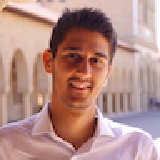

In [29]:
kian

In [30]:
def verify(image_path, identity, database, model):
    """
    Function that verifies if the person on the "image_path" image is "identity".
    
    Arguments:
        image_path -- path to an image
        identity -- string, name of the person you'd like to verify the identity. Has to be an employee who works in the office.
        database -- python dictionary mapping names of allowed people's names (strings) to their encodings (vectors).
        model -- your Inception model instance in Keras
    
    Returns:
        dist -- distance between the image_path and the image of "identity" in the database.
        door_open -- True, if the door should open. False otherwise.
    """
    # Compute the encoding for the image.
    encoding = img_to_encoding(image_path, model)
    # Compute distance with identity's image
    dist = np.linalg.norm(database[identity] - encoding)
    # Open the door if dist < 0.7, else don't open
    if dist < 0.7:
        print("It's " + str(identity) + ", welcome in!")
        door_open = True
    else:
        print("It's not " + str(identity) + ", please go away")
        door_open = False
     
    return dist, door_open

In [31]:
# Test
print(verify(basicPath+"images/camera_0.jpg", "younes", database, FRmodel))
print(verify(basicPath+"images/camera_2.jpg", "kian", database, FRmodel))

It's younes, welcome in!
(0.59929425, True)
It's not kian, please go away
(1.0259347, False)


### Face Recognition

In [32]:
def who_is_it(image_path, database, model):
    """
    Implements face recognition for the office by finding who is the person on the image_path image.
    
    Arguments:
        image_path -- path to an image
        database -- database containing image encodings along with the name of the person on the image
        model -- your Inception model instance in Keras
    
    Returns:
        min_dist -- the minimum distance between image_path encoding and the encodings from the database
        identity -- string, the name prediction for the person on image_path
    """
    
    ## Compute the target "encoding" for the image.
    encoding =  img_to_encoding(image_path, model)
    
    ## Find the closest encoding ##
    
    # Initialize "min_dist" to a large value
    min_dist = 100
    
    # Loop over the database dictionary's names and encodings.
    for (name, db_enc) in database.items():
        
        # Compute L2 distance between the target "encoding" and the current db_enc from the database.
        dist = np.linalg.norm(db_enc - encoding)

        # If this distance is less than the min_dist, then set min_dist to dist, and identity to name.
        if dist < min_dist:
            min_dist = dist
            identity = name
    
    if min_dist > 0.7:
        print("Not in the database.")
    else:
        print ("it's " + str(identity) + ", the distance is " + str(min_dist))
        
    return min_dist, identity

In [33]:
# Test 1 with Younes pictures 
who_is_it(basicPath+"images/camera_0.jpg", database, FRmodel)

# Test 2 with Younes pictures 
test1 = who_is_it(basicPath+"images/camera_1.jpg", database, FRmodel)

# Test 3 with Younes pictures 
test2 = who_is_it(basicPath+"images/younes.jpg", database, FRmodel)

it's younes, the distance is 0.59929425
it's bertrand, the distance is 0.5436483
it's younes, the distance is 0.0


<font color='blue'>
    
**What you should remember**:

- Face verification solves an easier 1:1 matching problem; face recognition addresses a harder 1:K matching problem.
    
- Triplet loss is an effective loss function for training a neural network to learn an encoding of a face image.
    
- The same encoding can be used for verification and recognition. Measuring distances between two images' encodings allows you to determine whether they are pictures of the same person.